In [165]:
import pandas as pd
import numpy as np
import plotnine as pn
import plotly.graph_objs as go
import plotly.express as px
from tqdm.notebook import tqdm
from IPython.display import clear_output, display
import os
from itertools import product
from pulp import (
    LpMaximize,
    LpMinimize,
    LpProblem,
    LpStatus,
    lpSum,
    LpVariable,
    LpContinuous,
    LpInteger,
    value
)
from itertools import product

from deap import base, creator, tools, algorithms
import imageio

background_colour = "#F2F2F2"
pn.theme_set(
    pn.theme_classic()
    + pn.theme(
        text=pn.element_text(family="monospace"),
        plot_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        panel_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        legend_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
    )
)

%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


### Reading the Price data

In [4]:
df = pd.read_csv("../01 - Data/example_week.csv")
df.head(2)

,spot,utc_time
0,101.54,2022-01-01 00:00:00+00:00
1,52.13,2022-01-01 01:00:00+00:00


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   spot      168 non-null    float64
 1   utc_time  168 non-null    object 
dtypes: float64(1), object(1)
memory usage: 2.8+ KB


### Formulating the MILP Problem

In [10]:
df.shape

(168, 2)

We have a week's worth of data, so we have 168 decisions to make on the hourly time scale.

The revenue at each hour is:

$$dt_i * P_{Turbine} * Spot_i + dp_i * P_{Pump} * Spot_i$$

In [218]:
plant_params = {
    "EFFICIENCY": 0.75,
    "MAX_STORAGE_M3": 5000,
    "MIN_STORAGE_M3": 0,
    "TURBINE_POWER_MW": 100,
    "PUMP_POWER_MW": 100,
    "TURBINE_RATE_M3H": 500,
    "MIN_STORAGE_MWH": 0,
    "INITIAL_WATER_LEVEL_PCT": 0,
}
plant_params["INITIAL_WATER_LEVEL"] = (
    plant_params["INITIAL_WATER_LEVEL_PCT"] * plant_params["MAX_STORAGE_M3"]
)
plant_params["PUMP_RATE_M3H"] = (
    plant_params["TURBINE_RATE_M3H"] * plant_params["EFFICIENCY"]
)
plant_params["MAX_STORAGE_MWH"] = (
    plant_params["MAX_STORAGE_M3"] / plant_params["TURBINE_RATE_M3H"]
) * plant_params["TURBINE_POWER_MW"]

# Create names for decision variables
dec_vars = range(df.shape[0])

# The cost/revenue associated with each decision variable is the
# spot price
spot = dict(zip(dec_vars, df["spot"].to_list()))

# Decision variables
dp = LpVariable.dicts("pump_dummy", dec_vars, 0, 1, cat="Binary")
dt = LpVariable.dicts("turbine_dummy", dec_vars, 0, 1, cat="Binary")

# State Variables
water_level = LpVariable.dict(
    "water_level",
    dec_vars,
    plant_params["MIN_STORAGE_M3"],
    plant_params["MAX_STORAGE_M3"],
    cat="Continuous",
)

# Initialise Model
model = LpProblem(name="pumped_storage_optimisation", sense=LpMaximize)

# Add objective function
model += (
    lpSum(
        [
            dt[i] * plant_params["TURBINE_POWER_MW"] * df["spot"][i]
            - dp[i] * plant_params["PUMP_POWER_MW"] * df["spot"][i]
            for i in dec_vars
        ]
    ),
    "revenue",
)

# Add constraints
for i in dec_vars:
    # Don't pump and turbine at the same time
    model += (dt[i] + dp[i] <= 1, f"no_simultaneous_pump_and_turbine_upper_{i}")
    model += (dt[i] + dp[i] >= 0, f"no_simultaneous_pump_and_turbine_lower_{i}")

    # Add constraint to update water level
    if i == 0:
        model += (
            water_level[i]
            == plant_params["INITIAL_WATER_LEVEL"]
            + dp[i] * plant_params["PUMP_RATE_M3H"]
            - dt[i] * plant_params["TURBINE_RATE_M3H"],
            f"initial_water_level_{i}",
        )
    else:
        # Update water level based on previous level, pumping, and turbine action
        model += (
            water_level[i]
            == water_level[i - 1]
            + dp[i] * plant_params["PUMP_RATE_M3H"]
            - dt[i] * plant_params["TURBINE_RATE_M3H"],
            f"water_level_update_{i}",
        )

    # Add constraints for water level boundaries
    model += (water_level[i] <= plant_params["MAX_STORAGE_M3"], f"max_storage_{i}")
    model += (water_level[i] >= plant_params["MIN_STORAGE_M3"], f"min_storage_{i}")


# Solve the model
model.solve()

1

In [222]:
(pd.DataFrame(
        {
            "variable": [v.name for v in model.variables()],
            "value": [v.value() for v in model.variables()],
        }
    )
    .assign(
        name=lambda x: x["variable"].apply(lambda r: r.rsplit("_", 1)[0]),
        hour=lambda x: x["variable"].apply(lambda r: r.rsplit("_", 1)[1]).astype(int),
    )
    .drop("variable", axis=1)
    .pivot(index="hour", columns="name", values="value")
    .reset_index()
    .rename_axis(None, axis=1)
    .sort_values("hour")
    )


,hour,pump_dummy,turbine_dummy,water_level
0,0,0.0,0.0,0.000000e+00
1,1,1.0,0.0,3.750000e+02
2,2,1.0,0.0,7.500000e+02
3,3,1.0,0.0,1.125000e+03
4,4,1.0,0.0,1.500000e+03
...,...,...,...,...
163,163,0.0,0.0,2.700997e-12
164,164,0.0,0.0,2.700997e-12
165,165,0.0,0.0,2.700997e-12
166,166,0.0,0.0,2.700997e-12


In [229]:
LpStatus[model.status]

'Optimal'

In [223]:
best_profile = (
    pd.DataFrame(
        {
            "variable": [v.name for v in model.variables()],
            "value": [v.value() for v in model.variables()],
        }
    )
    .assign(
        name=lambda x: x["variable"].apply(lambda r: r.rsplit("_", 1)[0]),
        hour=lambda x: x["variable"].apply(lambda r: r.rsplit("_", 1)[1]).astype(int),
    )
    .drop("variable", axis=1)
    .pivot(index="hour", columns="name", values="value")
    .reset_index()
    .rename_axis(None, axis=1)
    .sort_values("hour")
    .assign(
        action=lambda x: np.select(
            condlist=[
                x["pump_dummy"] == 1,
                x["turbine_dummy"] == 1,
            ],
            choicelist=[
                -1,
                1,
            ],
            default=0,
        ),
        colour_id=lambda x: np.select(
            condlist=[
                x["pump_dummy"] == 1,
                x["turbine_dummy"] == 1,
            ],
            choicelist=[
                "pump",
                "turbine",
            ],
            default="nothing",
        ),
        utc_time=pd.to_datetime(df["utc_time"]),
        spot=df["spot"].to_list(),
    )
    .drop(["pump_dummy", "turbine_dummy", "hour"], axis=1)
)

best_profile.describe()

,water_level,action,spot
count,168.000000,168.000000,168.000000
mean,2808.779762,-0.077381,160.277024
std,1391.061984,0.734089,70.981135
min,0.000000,-1.000000,0.950000
25%,1718.750000,-1.000000,97.170000
50%,3000.000000,0.000000,189.340000
75%,3656.250000,0.000000,211.595000
max,5000.000000,1.000000,266.580000


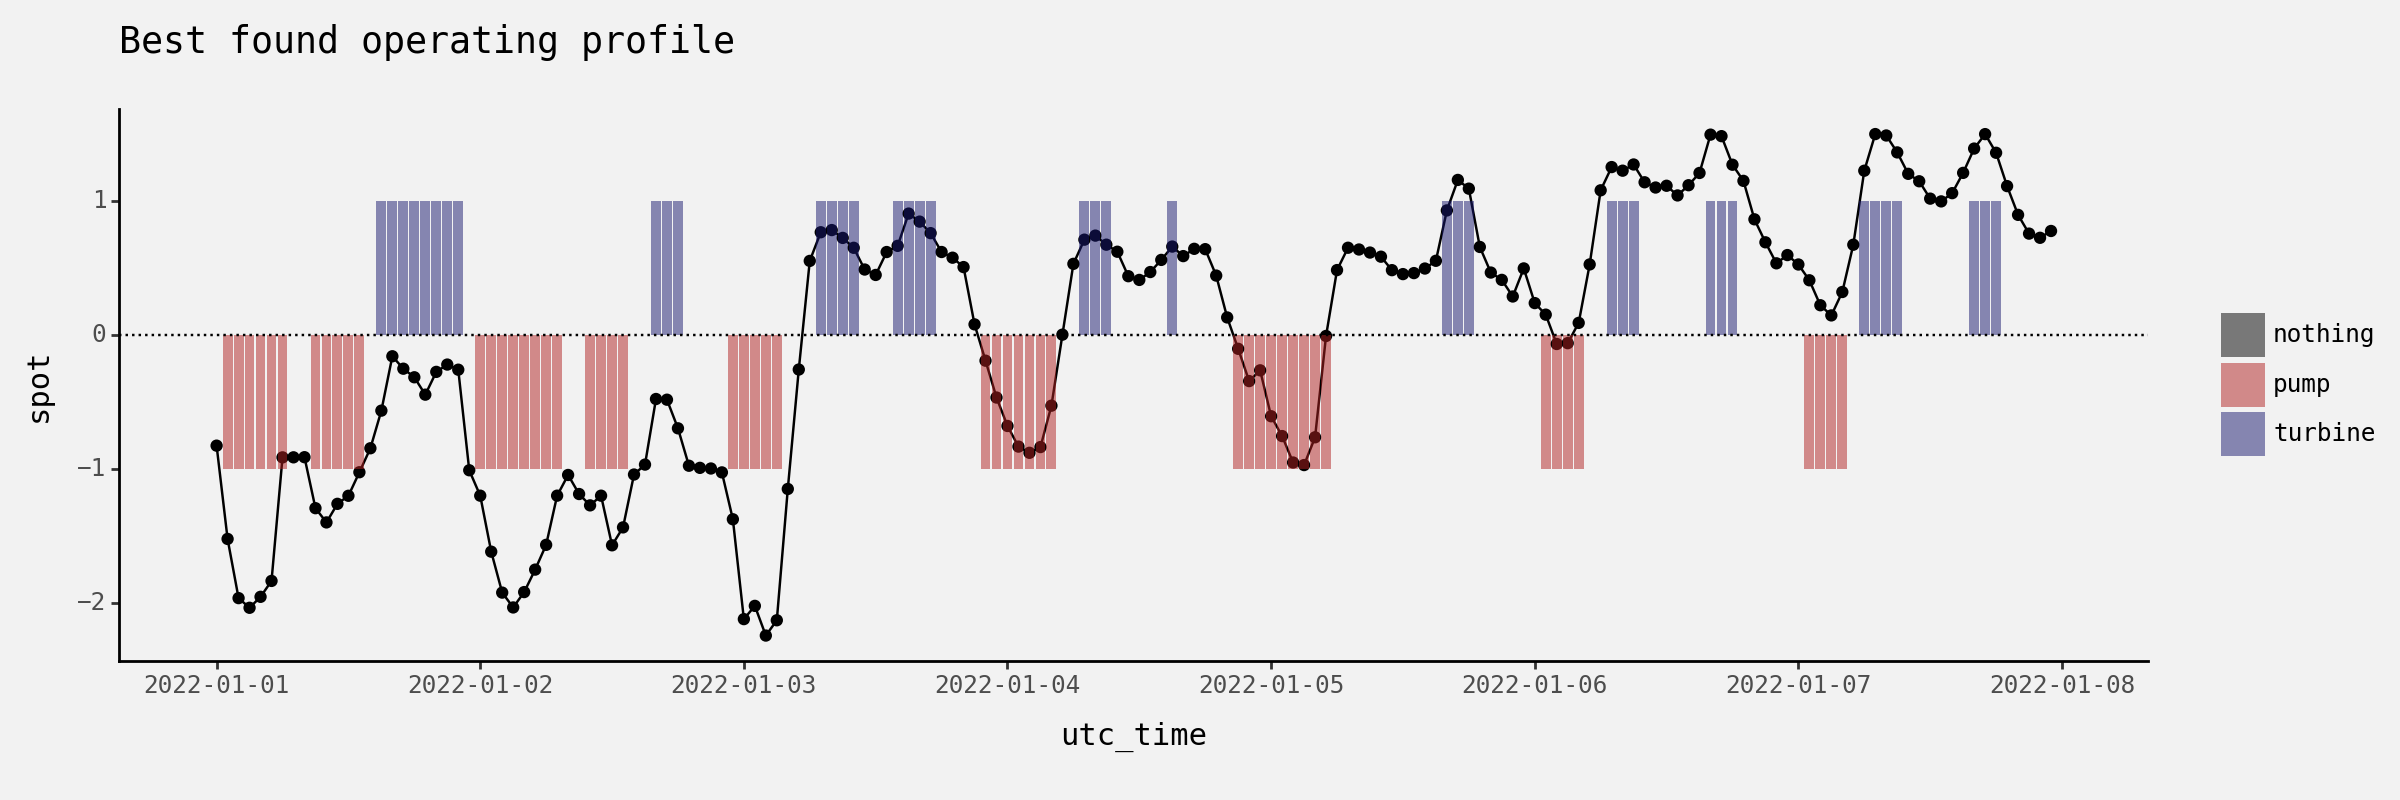

<Figure Size: (1200 x 400)>

In [225]:
(
    pn.ggplot(
        data=best_profile.assign(
            spot=lambda x: (x.spot - x.spot.mean()) / x.spot.std()
        ),
        mapping=pn.aes(x="utc_time"),
    )
    + pn.geom_line(pn.aes(y="spot"))
    + pn.geom_point(pn.aes(y="spot"))
    + pn.geom_col(pn.aes(y="action", fill="colour_id"), alpha=0.5)
    + pn.labs(title="Best found operating profile")
    + pn.scale_fill_manual(values=["black", "firebrick", "midnightblue"])
    + pn.geom_hline(yintercept=0, linetype="dotted")
    # + pn.scale_x_date(date_breaks="1 month", date_labels="%d/%m")
    + pn.theme(figure_size=[12, 4], legend_title=pn.element_blank())
)

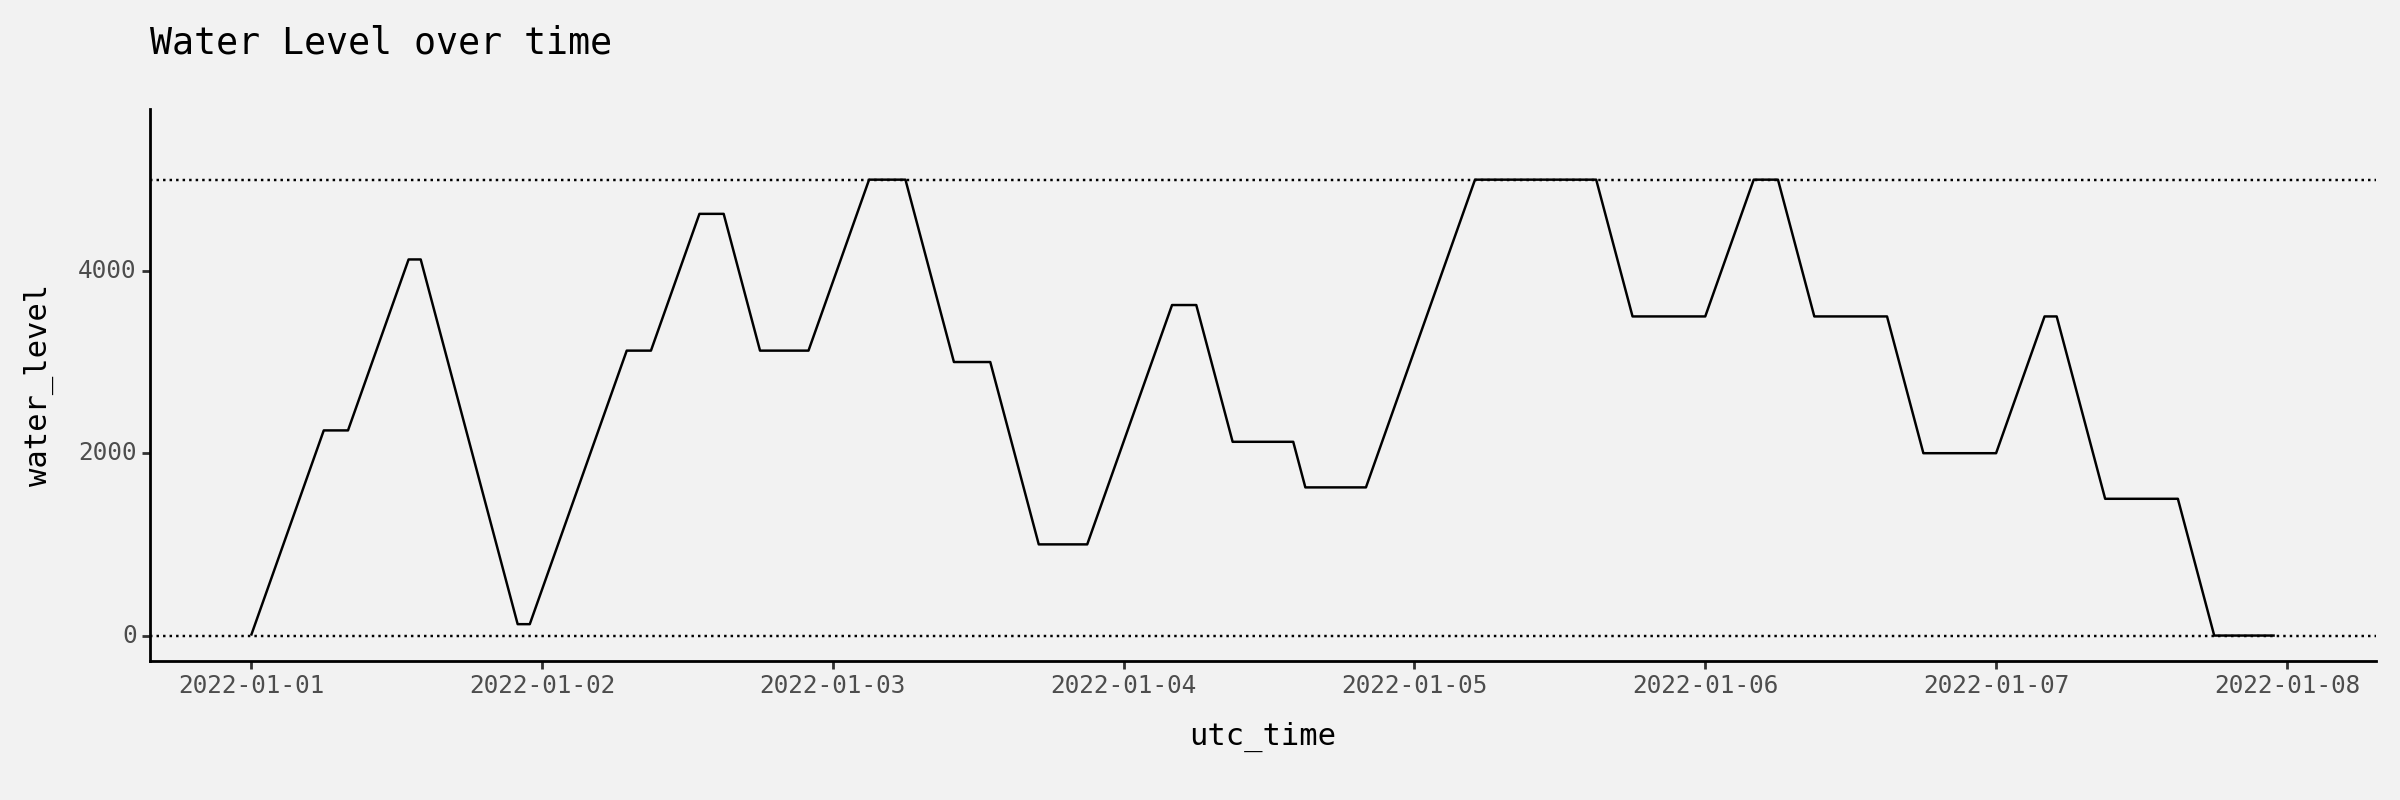

<Figure Size: (1200 x 400)>

In [226]:
(
    pn.ggplot(data=best_profile, mapping=pn.aes(x="utc_time", y="water_level"))
    + pn.geom_line()
    + pn.labs(title="Water Level over time")
    + pn.geom_hline(yintercept=plant_params["MAX_STORAGE_M3"], linetype="dotted")
    + pn.geom_hline(yintercept=plant_params["MIN_STORAGE_M3"], linetype="dotted")
    # + pn.scale_x_date(date_breaks="1 month", date_labels="%d/%m")
    + pn.coord_cartesian(ylim=[0, best_profile.water_level.max()*1.1])
    + pn.theme(figure_size=[12, 4], legend_title=pn.element_blank())
)

In [216]:
LpStatus[model.status]

'Optimal'

In [215]:
model.objective.value()

350291.0